In [1]:
import sys
import os
base_path = "/Users/giuseppe/Documents/Projects/RL_sim/"
sys.path.insert(0, base_path)
os.chdir(base_path)

from agents.soft_q_learner import SoftQAgent
from agents.utils import *
from posixpath import join
from PIL.ImageOps import invert
from PIL import Image
from IPython import display

import matplotlib.pyplot as plt
import gymnasium as gym
import checkerboard_env
import pandas as pd
import numpy as np
import time

In [2]:
from itertools import product

# Add parameter search;
parameters = {
    'snr': [3.3], #3.31],
    'n_bins': [10],
    'q_mean': [0],
    'q_sigma': [0.1],
    'kernel_size': [20],       # n_bins + 2
    'kernel_sigma': [4.0],     # >= n_bins**2 / n_epochs
    'learning_rate': [0.02],
    'temperature': [0.08],
    'min_temperature': [1e-5],
    'max_temperature': [1.0],
    'reduce_temperature': [False],
    'decay_rate': [0.001]
}

# Generate all possible combinations
combinations = list(product(*parameters.values()))

# Convert the combinations into a list of dictionaries
parameter_combinations = [dict(zip(parameters.keys(), values)) for values in combinations]

# use one combination:
params = parameter_combinations[0]

In [3]:
# Convergence;
# def euclidean_2D(x, v):
#     distance = [np.sqrt(np.sum([(b[0] - a[0])**2, (b[1] - a[1])**2])) for a, b in zip(x, v)]
#     return np.mean(distance)

# def test_convergence(maxima, window_size):
#     return euclidean_2D(maxima[-window_size:-1], maxima[-(window_size-1):])

In [4]:
def load_checkerboard(img, cross):
    
    board = Image.open(img)
    cross = Image.open(cross)

    if board.mode == 'RGBA':
        r,g,b,a = board.split()
        rgb_image = Image.merge('RGB', (r,g,b))
        rgb_inverse = invert(rgb_image)

        r2,g2,b2 = rgb_inverse.split()
        inverse = Image.merge('RGBA', (r2,g2,b2,a))

    else:
        inverse = invert(board)
    
    return board, inverse, cross

def euclidean_2D(x, v):
    x = np.array(x)
    v = np.array(v)
    distance = np.sqrt((x[:, 0] - v[:, 0])**2 + (x[:, 1] - v[:, 1])**2)
    return np.mean(distance)

def test_convergence(maxima, current_window_size):
    previous_window = maxima[-current_window_size:-1]
    current_window = maxima[-(current_window_size - 1):]
    return euclidean_2D(previous_window, current_window)


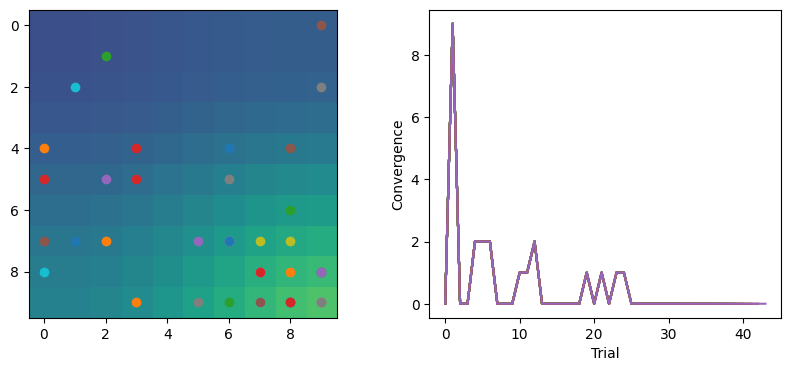

In [5]:
assets_path = "checkerboard_env/assets/"
board, inverse, cross = load_checkerboard(
    join(base_path, assets_path + "checkerboard.png"),
    join(base_path, assets_path + "cross.png")
)

env = gym.make('checkerboard-v0',
        render_mode=None,
        checkerboard=board,
        inverse=inverse,
        cross=cross,
        snr=params["snr"])

NUM_BINS = params["n_bins"]
BINS = create_bins(NUM_BINS)

q_table_shape = (NUM_BINS, NUM_BINS)  # contrast * frequency;
# q_table = np.random.normal(params["q_mean"], params["q_sigma"], q_table_shape)
q_table = np.ones(q_table_shape) * 2
kernel = generate_gaussian_kernel(params["kernel_size"], params["kernel_sigma"])

model = SoftQAgent(
    env,
    q_table,
    kernel,
    learning_rate=params["learning_rate"],
    temperature=params["temperature"],
    min_temperature=params["min_temperature"],
    max_temperature=params["max_temperature"],
    reduce_temperature=params["reduce_temperature"],
    decay_rate=params["decay_rate"],
    num_bins_per_obs=NUM_BINS
)

initial_state = model.env.reset()[0]
discrete_state = discretize_observation(initial_state, BINS)

# Create a figure for the Q-table visualization
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

n_epochs = 45
window = 2
maxima = []
convergence = []
action_log = []

# fit the model;
for current_epoch in range(n_epochs):
    if current_epoch == 0:
        action = initial_state

    (observation,
    reward,
    terminated,
    truncated,
    info) = model.env.step(action)

    action_log.append(observation)

    # grab current q-value;
    old_q_value = model.q_table[discrete_state]

    # compute next q-value and update q-table;
    model.q_table = model.update_q_table(reward, discrete_state, old_q_value)
    action = model.soft_q_action_selection()

    # update and discretize the next state;
    next_state_discrete = discretize_observation(action, BINS)
    discrete_state = next_state_discrete

    # by default keep temperature constant;
    model.reduce_temperature(current_epoch, reduce=model.reduce_temp)
    model.reward_log.append(reward)

    # compute the norm of the difference from the previous max location to this
    # look at the average of this norm fro the last x (3-5) trials
    max_index = np.unravel_index(np.argmax(model.q_table), q_table_shape)
    maxima.append(max_index)

    if len(maxima) >= window:
        convergence.append(test_convergence(maxima, window))

    # Display the Q-table
    ax1.imshow(model.q_table, cmap='viridis', vmin=1.5, vmax=3.5)
    ax1.plot(action[1]*NUM_BINS, action[0]*NUM_BINS, "o")
    ax2.plot(convergence)
    ax2.set_xlabel("Trial")
    ax2.set_ylabel("Convergence")
    display.display(fig)
    display.clear_output(wait=True)
    
    # Optional: You can add a small delay to make the visualization smoother
    time.sleep(0.1)

In [11]:
def get_q_table_steps(action_log, num_bins):
    steps = []
    for data in action_log:
        contrast = data[0]
        frequency = data[1]
        bins = create_bins(num_bins)
        steps.append(discretize_observation([contrast, frequency], bins))
    return steps

def plot_q_table_steps(last_table, action_log):
    maxima = np.array(get_q_table_steps(action_log, 10)) + 1 # adjust discretization;
    steps = np.random.randint(0, len(maxima), len(maxima))

    plt.imshow(last_table)
    plt.xlabel("Frequency", fontsize=16)
    plt.ylabel("Contrast", fontsize=16)
    plt.colorbar().set_label("Q-value", fontsize=16)
    plt.plot(maxima[:, 1], maxima[:, 0], "--", alpha=0.4)
    plt.scatter(maxima[:, 1], maxima[:, 0], c=steps, cmap='plasma', alpha=0.5)
    plt.colorbar().set_label("Trial number", fontsize=16)
    plt.title(f"Simulation result", fontsize=20)
    plt.show()

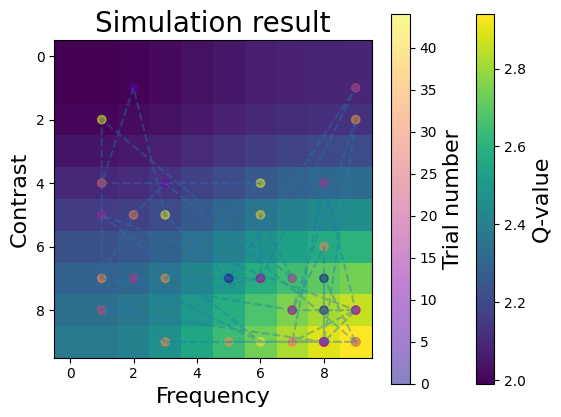

In [12]:
plot_q_table_steps(model.q_table, action_log)

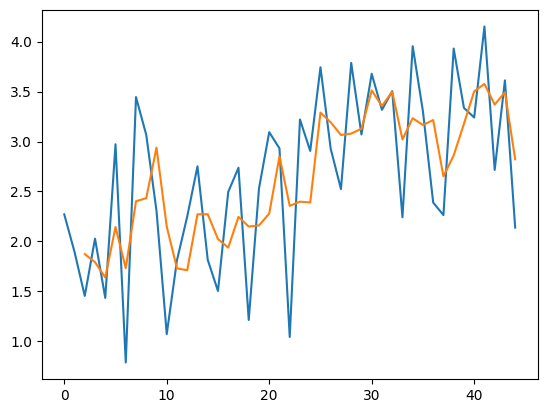

In [13]:
rolling_mean = pd.Series(model.reward_log).rolling(window=3).mean()
plt.plot(model.reward_log)
plt.plot(rolling_mean)


Text(0, 0.5, 'Reward')

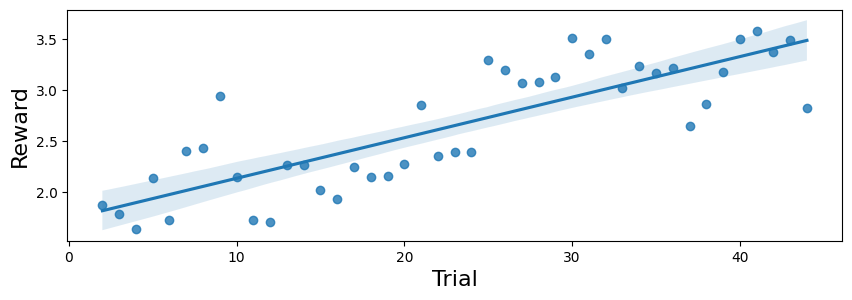

In [14]:
import seaborn as sns
plt.figure(figsize=(10, 3))
sns.regplot(y=rolling_mean, x=np.array(range(len(rolling_mean))))
plt.xlabel("Trial", fontsize=16)
plt.ylabel("Reward", fontsize=16)

Text(0, 0.5, 'Convergence')

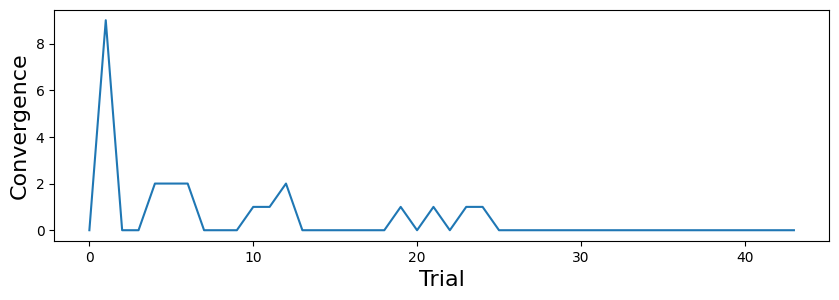

In [15]:
plt.figure(figsize=(10, 3))
plt.plot(convergence)
plt.xlabel("Trial", fontsize=16)
plt.ylabel("Convergence", fontsize=16)